# Bayesian Logistic Regression Modelling for Back Pain Abnormality
<b>Numaer Zaker \<nzaker3@gatech.edu\><b/><br/>
<b>IsYE 6420 - Bayesian Statistics - Fall 2020<b/><br/>
<b>Georgia Institute of Technology</b><br/>
Dataset Source: https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [2]:
""" We read in the spine dataset into a pandas dataframe.
We also encode our categorical variable, "back_status" into a binary variable
(Abnormal = 1, Normal = 0)

We see that the result is 310 data points and 15 columns.
"""

spine_features = ['pelvic_incidence', 
                              'pelvic_tilt', 
                              'lumbar_lordosis_angle',
                              'sacral_slope', 
                              'pelvic_radius',
                              'degree_spondylolisthesis', 
                              'pelvic_slope',
                              'direct_tilt', 
                              'thoracic_slope', 
                              'cervical_tilt',
                              'sacrum_angle', 
                              'scoliosis_slope']

raw_data = pd.read_csv("./dataset_spine.csv",
                       header=None,
                       skiprows=[0],
                       names=spine_features +
                              ['back_status',
                              'notes'])

raw_data['binary_back_status'] = raw_data['back_status'].apply(lambda x: 1 if (x == 'Abnormal') else 0)
print(raw_data.shape)
raw_data.head()

(310, 15)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,back_status,notes,binary_back_status
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN,1


In [3]:
""" We use the pandas describe() function to get an overview of our data.
"""

display(raw_data[raw_data.columns[:6]].describe())
display(raw_data[raw_data.columns[6:]].describe())

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,binary_back_status
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,0.472979,21.321526,13.064511,11.933317,-14.053139,25.645981,0.677419
std,0.285787,8.639423,3.399713,2.893265,12.225582,10.450558,0.468220
min,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900,0.000000
25%,0.224367,13.054400,10.417800,9.541140,-24.289522,17.189075,0.000000
50%,0.475989,21.907150,12.938450,11.953835,-14.622856,24.931950,1.000000
75%,0.704846,28.954075,15.889525,14.371810,-3.497094,33.979600,1.000000
max,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200,1.000000


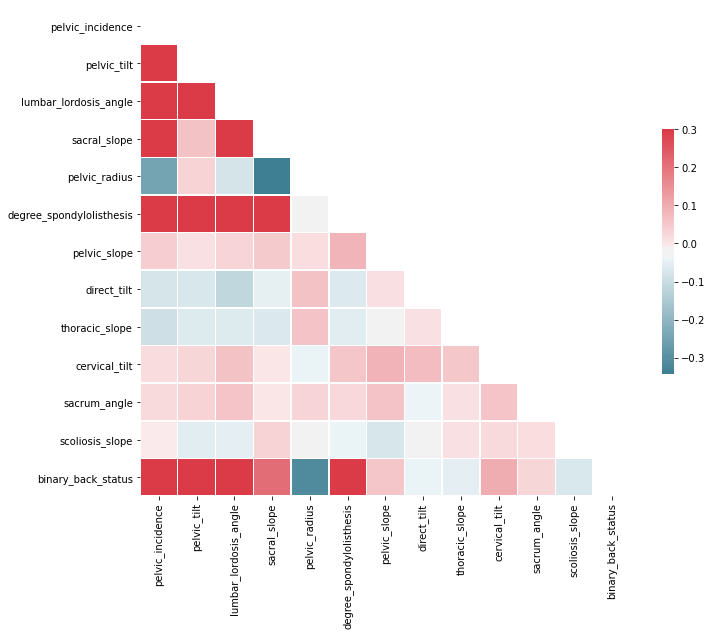

In [4]:
""" We show the correlation matrix between all our columns. We are looking for to prune features with high collinearity
and weak correlation with responsee
"""

corr = raw_data[spine_features + ['binary_back_status']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

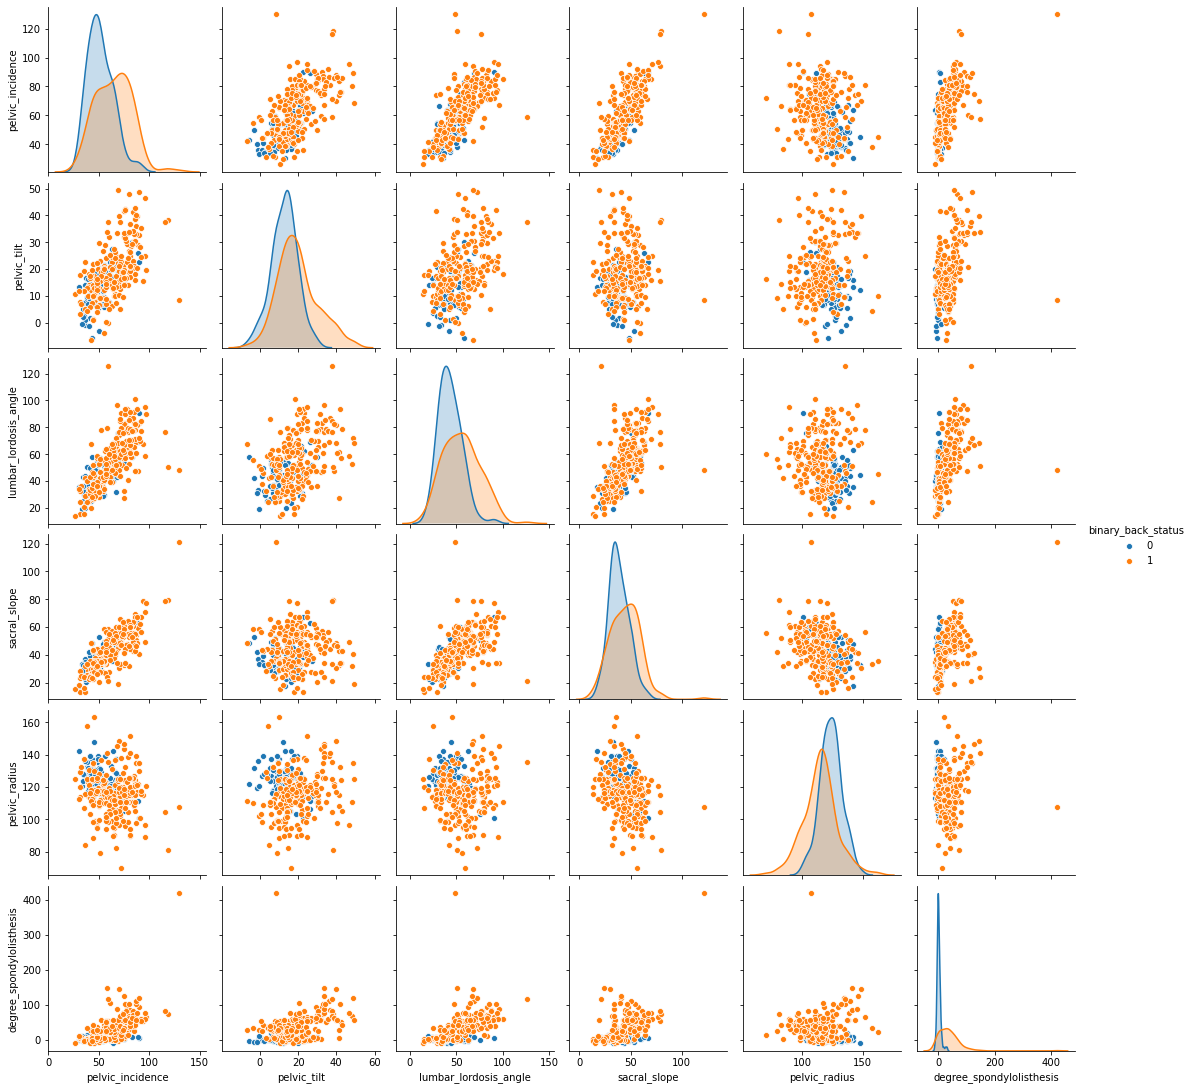

In [5]:
""" Here we plot the scatterplot correlation matrix, while color
encoding abnormal=1 as orange, and normal=0 as blue. This will let us discover
patterns with our bare eyes to help us further select better predictors for our model
"""

SELECTED_FEATURES = ['pelvic_incidence',
                     'pelvic_tilt', 
                      'lumbar_lordosis_angle',
                      'sacral_slope',
                      'pelvic_radius',
                      'degree_spondylolisthesis']

g = sns.pairplot(raw_data[SELECTED_FEATURES + ['binary_back_status']], hue="binary_back_status")

Variable selection is a very important process for any sort of regression modelling. We want to select features that maintain the common assumptions for most regression models which is:

* Little or no multicollinearity amongst the predictors
* Observations should be independent of one another

From the covariance scatter matrix above, we look 

In [6]:
""" As is standard practice with predictive modelling, we want to split our dataset
into training and testing. We will build our bayesian logistic regression model for training
and test it's accuracy on the test dataset.

We do a 80/20 split, where 80% is training and 20% is testing.
"""

SELECTED_FEATURES = ['pelvic_tilt', 
                      'lumbar_lordosis_angle',
                      'pelvic_radius',
                      'degree_spondylolisthesis']

X_train, X_test, y_train, y_test = train_test_split(raw_data[spine_features], raw_data['binary_back_status'], test_size=0.20, random_state=1337)
train_df = pd.concat([X_train, y_train], axis=1)
print(train_df.shape)
train_df.head()

(248, 13)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,binary_back_status
28,44.551012,21.931147,26.785916,22.619865,111.072920,2.652321,0.527891,32.4275,10.2244,11.71324,-28.506125,28.0470,1
261,74.976021,14.921705,53.730072,60.054317,105.645400,1.594748,0.318967,13.2564,11.3042,13.47166,-20.789258,41.2149,0
249,50.753290,20.235060,37.000000,30.518231,122.343516,2.288488,0.147745,28.9054,14.5673,11.98326,-26.881964,10.3342,0
56,43.349606,7.467469,28.065483,35.882137,112.776187,5.753277,0.592034,14.3377,14.2176,9.64034,-12.480751,13.0244,1
29,66.879211,24.891999,49.278597,41.987212,113.477018,-2.005892,0.677268,12.4271,8.2495,7.58784,-3.963385,27.3587,1


In [7]:
""" Now we finally build our Bayesian logistic regression model with specifications:

* Our beta coefficients will follow noninformative priors of Normal(0, sigma)
* We use the No U-Turn (NUTS) sampler which on averaged converges faster than Gibbs and Metropolis-Hastings
* We run for 1000 samples
"""

with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('binary_back_status ~ pelvic_tilt + lumbar_lordosis_angle + pelvic_radius + degree_spondylolisthesis',
                            train_df[['binary_back_status'] + SELECTED_FEATURES],
                            family=pm.glm.families.Binomial())
    trace = pm.sample(1000, tune=1000, init='adapt_diag')
pm.summary(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [degree_spondylolisthesis, pelvic_radius, lumbar_lordosis_angle, pelvic_tilt, Intercept]
Sampling 4 chains, 0 divergences: 100%|█| 8000/8000 [00:29<00:00, 272.04draws/s
The acceptance probability does not match the target. It is 0.8810241840319522, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,9.853,2.719,4.734,14.874,0.071,0.050,1460.0,1460.0,1456.0,1993.0,1.0
pelvic_tilt,0.115,0.034,0.052,0.179,0.001,0.001,2296.0,2091.0,2320.0,2043.0,1.0
lumbar_lordosis_angle,-0.074,0.018,-0.108,-0.039,0.000,0.000,1764.0,1764.0,1759.0,2271.0,1.0
pelvic_radius,-0.078,0.020,-0.117,-0.041,0.001,0.000,1537.0,1537.0,1534.0,2033.0,1.0
degree_spondylolisthesis,0.169,0.026,0.119,0.216,0.001,0.000,1977.0,1898.0,2028.0,1924.0,1.0


F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
F:\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


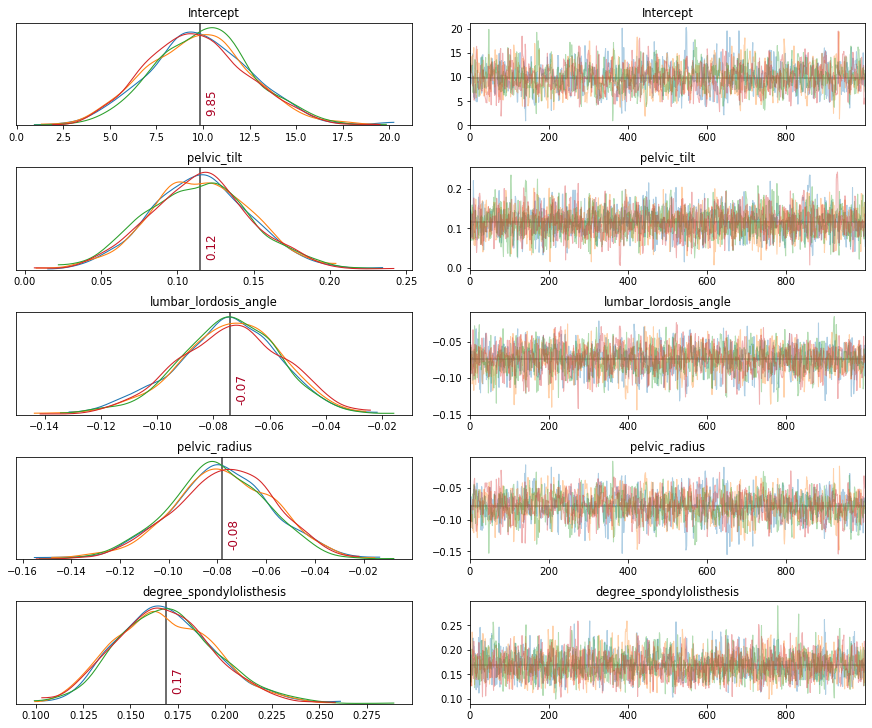

In [8]:
""" Plot our sample traces for each of our random variables. 
This visually shows us the posterior distributions for each of our random variables.
We also get to see if they successfuly converged
"""

retain=0
ax = pm.traceplot(trace[-retain:],
                  lines=tuple([(k, {}, v['mean'])
                               for k, v in pm.summary(trace[-retain:]).iterrows()]))

for i, mn in enumerate(pm.summary(trace[-retain:])['mean']):
    ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                ,xytext=(5,10), textcoords='offset points', rotation=90
                ,va='bottom', fontsize='large', color='#AA0022')

# Bayesian Logistic Regression Prediction & Evaluation

We see that all our predictors converged as the charts as all our regression coefficients have the kernel of a normal distribution (similar to our prior). We also see that the samples over time on the chart for all predictors show no abrupt pattern and remain consistent

# Correctly Classified:  53
# Incorrectly Classified:  9
% Model Accuracy:  85.48


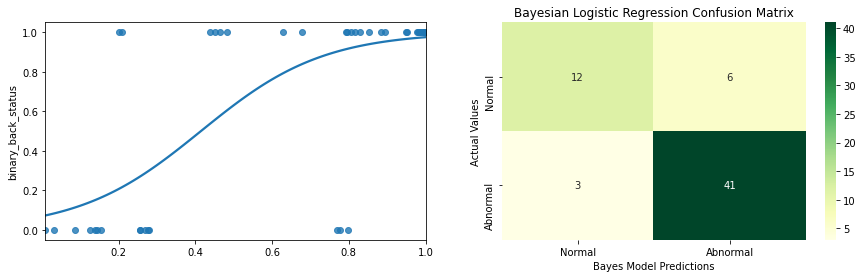

In [12]:
def predict_spine_probability(x):
    """ Calculate the probability of a single data point as a posterior predictive distribution
    We take the mean to give us the best single point estimate
    """

    x = x.values
    pelvic_tilt, lumbar_lordosis_angle, pelvic_radius, degree_spondylolisthesis = x[0], x[1], x[2], x[3]
    shape = np.broadcast(pelvic_tilt, lumbar_lordosis_angle, pelvic_radius, degree_spondylolisthesis).shape
    x_norm = np.asarray([np.broadcast_to(x, shape)
                         for x in [pelvic_tilt, lumbar_lordosis_angle, pelvic_radius, degree_spondylolisthesis]])
    return 1 / (1 + np.exp(-(trace['Intercept'] +
                             trace['pelvic_tilt']*x_norm[0] +
                             trace['lumbar_lordosis_angle']*x_norm[1] +
                             trace['pelvic_radius']*x_norm[2] +
                             trace['degree_spondylolisthesis']*x_norm[3])))

# Predict probability of abnormality and normality from our bayesian model using trace coefficients
y_hat = X_test[SELECTED_FEATURES].apply(predict_spine_probability, axis=1)

""" Predict the probability of spine abnormality and calculate accuracy on our testing out
Note: Since our prediction is on the interval of [0,1], we classify a
spine as abnormal if the prediction is above 50% and normal if below 50%.
"""
y_hat_mean = y_hat.apply(lambda x: x.mean())
y_hat_pred = y_hat_mean.apply(lambda x: 1 if x > 0.5 else 0)
prediction_results = np.unique((y_hat_pred == y_test), return_counts=True)


""" Below we plot how our logistic regression model classified points. 
Anywhere where x>0.5 it detects as abnormal back, whereas x<0.5 is normal back.
Where y=1 indicates the spine actually being abnormal and y=0 means a normal back.

We also plot the confusion matrix
"""

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(15)
sns.heatmap(confusion_matrix(y_hat_pred, y_test), annot=True, cmap="YlGn", ax=ax2)
ax2.set_xlabel('Bayes Model Predictions')
ax2.set_ylabel('Actual Values')
ax2.set_title('Bayesian Logistic Regression Confusion Matrix'); 
ax2.xaxis.set_ticklabels(['Normal', 'Abnormal']); 
ax2.yaxis.set_ticklabels(['Normal', 'Abnormal']);
print("# Correctly Classified: ", prediction_results[1][1])
print("# Incorrectly Classified: ", prediction_results[1][0])
print("% Model Accuracy: ", 100*round(prediction_results[1][1] / (prediction_results[1][1] + prediction_results[1][0]),4))

sns.regplot(y=y_test, x=y_hat_mean, logistic=True, ax=ax1)